<a href="https://colab.research.google.com/github/lusiaulia/Prediksi_ISPU_BandarLampung/blob/main/Prediksi_ISPU_BDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
from numpy import array
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from sklearn.metrics import mean_squared_error,  mean_absolute_error, mean_absolute_percentage_error

In [ ]:
# Clone dataset dari github
!git clone https://github.com/lusiaulia/Prediksi_ISPU_BandarLampung.git
# mendefinisikan dataframe
df = pd.read_excel("/content/Prediksi_ISPU_BandarLampung/Data/AQI_BDL_Maret-Okt.xlsx") #Data penyusun ISPU
dw = pd.read_excel("/content/Prediksi_ISPU_BandarLampung/Data/Weather_BDL_Maret-Okt.xlsx") #Data meteorologi
d_test = pd.read_excel("/content/Prediksi_ISPU_BandarLampung/Data/AQI_BDL_Nov.xlsx") #Data penyusun ISPU untuk test
dw_test = pd.read_excel("/content/Prediksi_ISPU_BandarLampung/Data/Weather_BDL_Nov.xlsx")#Data meteorologi untuk test
#Mengurangi kolom yang tidak diperlukan
df = df.drop(['Unnamed: 0'],axis=1)
d_test = d_test.drop(['Unnamed: 0'],axis=1)
#Menyatukan kolom
df['rh'] = dw['rh']
df['temp'] = dw['temp']
df['wind_spd'] = dw['wind_spd']
d_test['rh'] = dw_test['rh']
d_test['temp'] = dw_test['temp']
d_test['wind_spd'] = dw_test['wind_spd']
df.describe()

Cloning into 'Prediksi_ISPU_BandarLampung'...
remote: Enumerating objects: 85, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 85 (delta 3), reused 0 (delta 0), pack-reused 74
Receiving objects: 100% (85/85), 5.40 MiB | 7.08 MiB/s, done.
Resolving deltas: 100% (22/22), done.


,pm10,pm25,o3,so2,no2,co,rh,temp,wind_spd
count,5872.000000,5875.000000,5872.000000,5854.000000,5869.000000,5866.000000,5880.000000,5880.000000,5880.000000
mean,49.252256,41.987779,24.631480,2.201384,6.470257,794.071741,80.679932,26.564201,1.885861
std,40.401458,37.663592,23.824031,1.695862,3.817150,364.903872,11.849970,2.808715,1.192324
min,1.980000,1.090000,0.000000,0.000000,0.000000,0.000000,41.000000,21.400000,0.000000
25%,18.465000,13.240000,7.187500,1.100000,3.710000,505.520000,72.000000,24.200000,1.080000
50%,38.465000,30.860000,17.490000,1.680000,5.990000,747.560000,84.000000,25.900000,1.600000
75%,68.225000,58.130000,34.017500,2.747500,8.330000,1025.352500,90.000000,28.800000,2.400000
max,250.290000,226.020000,161.760000,14.130000,49.270000,2247.930000,100.000000,34.300000,22.100000


Berikut di atas merupakan statistik deskriptif dari data parameter ISPU dan data meteorologi.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5880 entries, 0 to 5879
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  5880 non-null   datetime64[ns]
 1   pm10      5872 non-null   float64       
 2   pm25      5875 non-null   float64       
 3   o3        5872 non-null   float64       
 4   so2       5854 non-null   float64       
 5   no2       5869 non-null   float64       
 6   co        5866 non-null   float64       
 7   rh        5880 non-null   int64         
 8   temp      5880 non-null   float64       
 9   wind_spd  5880 non-null   float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 459.5 KB


<Axes: >

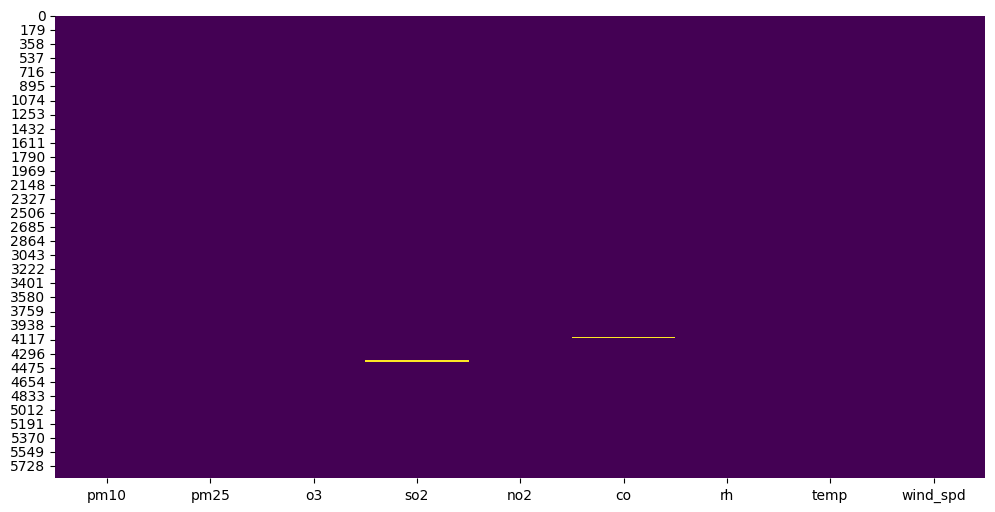

In [ ]:
df_time = df["datetime"]
df = df.drop(['datetime'],axis=1)
# Plot null data
mpl.rcParams['figure.figsize'] = (12, 6)
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

In [ ]:
# Total null data
print(df.isnull().sum())
print('shape:', df.shape)

pm10         8
pm25         5
o3           8
so2         26
no2         11
co          14
rh           0
temp         0
wind_spd     0
dtype: int64
shape: (5880, 9)


Tidak ada data kosong pada data meteorologi

In [ ]:
indicator = ['pm10','pm25','o3','so2','no2','co','rh','temp','wind_spd']
# #[1] Menghapus Data Kosong
# df.dropna(inplace=True)

#[2]Mengisi Data Kosong dengan Nilai Mean
for i in indicator :
  mean = df[i].mean()
  df[i] = df[i].replace(np.nan, mean)

# #[3] Mengisi Data Kosong dengan Nilai Median
# for i in indicator :
#   median = df[i].median()
#   df[i] = df[i].replace(np.nan, median)

# #[4] Mengisi Data Kosong dengan Nilai 0
# for i in indicator:
#   df[i] = df[i].replace(np.nan, 0)

<Axes: >

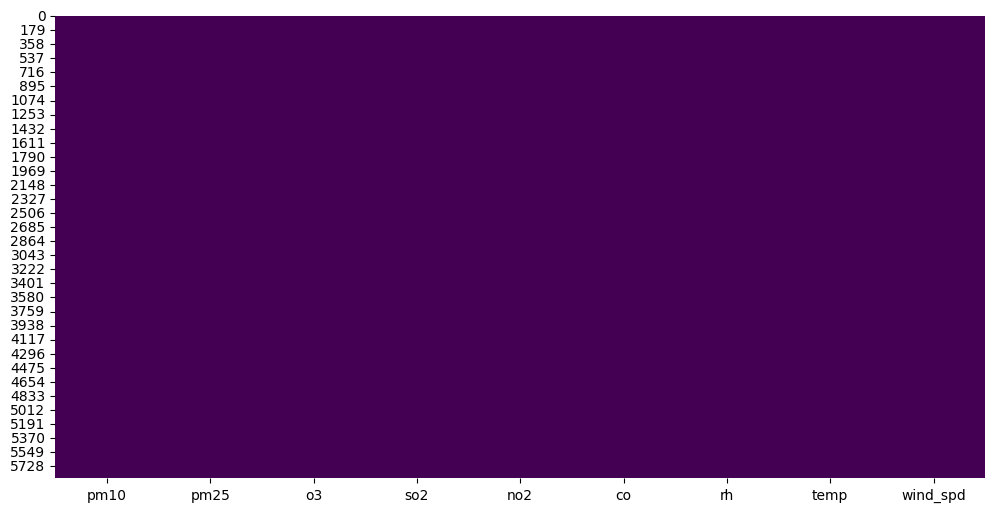

In [ ]:
#Visualisasi Heatmap Setelah Pengisian Data Kosong
mpl.rcParams['figure.figsize'] = (12, 6)
sns.heatmap(df.isnull(),cbar=False,cmap='viridis')

In [ ]:
df = df[indicator]

Sekarang kita lihat apakah ada outliers. Outlier harus kita antisipasi karena outlier dapat meningkatkan nilai error dan bias, khususnya saat
kita menerapkan uji statistik pada data. Saat kita memiliki banyak data dan sedikit outlier, Sampel lain tidak akan dirugikan dengan
menghapus outlier yang meragukan.

In [ ]:
def get_outliers(df):
    # Menghitung pessentile 25 dan 75
    p75 = df.quantile(0.75)
    p25 = df.quantile(0.25)
    # Menghitung IQR dengan selisih persentil 75 dan 25
    iqr = p75 - p25
    min_val = p25 - 1.5*iqr
    max_val = p75 + 1.5*iqr

    # Apapun dibawah minimum atau diatas maximum, disebut sebagai outlier
    outliers = df[(df < min_val) | (df > max_val)]
    return outliers

def replace_outliers(df,ds): #untuk mengganti nilai outlier
  m = df.mean()
  for x in df:
    for i in ds:
      if x == i:
        df = df.replace(x,m)
  return df

for i in indicator :#menghitung jumlah outlier yang ada
  print(f" Outlier {i} sebesar {round((len(get_outliers(df[i]))/len(df[i]))*100)}% atau {len(get_outliers(df[i]))} outliers dari total {len(df[i])} data")

 Outlier pm10 sebesar 3% atau 199 outliers dari total 5880 data
 Outlier pm25 sebesar 4% atau 243 outliers dari total 5880 data
 Outlier o3 sebesar 5% atau 303 outliers dari total 5880 data
 Outlier so2 sebesar 6% atau 344 outliers dari total 5880 data
 Outlier no2 sebesar 3% atau 154 outliers dari total 5880 data
 Outlier co sebesar 1% atau 55 outliers dari total 5880 data
 Outlier rh sebesar 0% atau 8 outliers dari total 5880 data
 Outlier temp sebesar 0% atau 0 outliers dari total 5880 data
 Outlier wind_spd sebesar 3% atau 199 outliers dari total 5880 data


Nilai outlier dari masing masing data semuanya memiliki presentase yang sedikit sehingga tidak perlu dilakukan penggantian nilai atau penghapusan outlier. Sekarang kita cek untuk korelasi.

Waktunya untuk cek korelasinya. Korelasi memiliki rentang sebagai berikut :
*   0 : Tidak ada korelasi antar variabel
*   0-0.25 : Korelasi sangat lemah
*   0.25-0.5 : Korelasi cukup
*   0.5-0.75 : Korelasi kuat
*   1 : Korelasi hubungan sempurna positif
*  -1 : Korelasi hubungan sempurna negatif










o3 memiliki korelasi sangat rendah (perbaikan : tidak baik jika diprediksi bersamaan dengan pm10, co, pm25, no2, dan so2)

In [ ]:
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		if out_end_ix > len(sequences):
			break
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

total_dataset = len(df)
df_train = df_scaled[:int(total_dataset*0.80)]
df_test = df_scaled[int(total_dataset*0.80):total_dataset]

print('Data for train:', df_train.shape)
print('Total day for train:', round(df_train.shape[0]/24))
print('\nData for test:', df_test.shape)
print('Total day for test:', round(df_test.shape[0]/24))

Data for train: (4704, 9)
Total day for train: 196

Data for test: (1176, 9)
Total day for test: 49


In [ ]:
#Memilih angka timestep
n_steps_in, n_steps_out = 24,1
x_train, y_train = split_sequences(df_train, n_steps_in, n_steps_out)
x_test, y_test = split_sequences(df_test, n_steps_in, n_steps_out)
n_features = x_train.shape[2]

print('Data input structure for training',x_train[0])
print('\nData output structure for validation', y_test[0])

Data input structure for training [[0.23635778 0.16938603 0.02052423 0.13234253 0.17475137 0.47245688
  0.77966102 0.18604651 0.02352941]
 [0.23744513 0.17881119 0.01965875 0.09271054 0.15709357 0.47151824
  0.79661017 0.15503876 0.05882353]
 [0.19491764 0.15200285 0.03041543 0.07784855 0.14998985 0.42113856
  0.83050847 0.13953488 0.09502262]
 [0.15239016 0.1251945  0.04117211 0.06298655 0.14268317 0.37075443
  0.84745763 0.10852713 0.11764706]
 [0.1098224  0.09843062 0.05192878 0.04741684 0.13557946 0.32037474
  0.84745763 0.10852713 0.11900452]
 [0.09967379 0.08842751 0.053227   0.05237084 0.12401055 0.30274964
  0.81355932 0.10852713 0.10452489]
 [0.08952519 0.0784244  0.05452522 0.05661713 0.11264461 0.28512454
  0.77966102 0.11627907 0.09411765]
 [0.07937659 0.06846574 0.05588526 0.06086341 0.10107571 0.26750388
  0.74576271 0.17829457 0.08597285]
 [0.07716161 0.06424221 0.0754822  0.07006369 0.09823422 0.2653241
  0.62711864 0.24031008 0.08914027]
 [0.07494664 0.06001867 0.09514

In [ ]:
print('Total fitur:', n_features)
print('Total data train:', x_train.shape)
print('Total data validasi:', y_train.shape)
print('Total data tes:', x_test.shape)
print('Total data tes validasi:', y_test.shape)

Total fitur: 9
Total data train: (4680, 24, 9)
Total data validasi: (4680, 1, 9)
Total data tes: (1152, 24, 9)
Total data tes validasi: (1152, 1, 9)


In [ ]:
tf.keras.backend.clear_session()
# define model
model = Sequential()
model.add(LSTM(100,input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))

In [ ]:
model.summary()

In [ ]:
# init_weights = model.get_weights()
# first_layer_weights = model.layers[0].get_weights()[0]
# first_layer_biases = model.layers[0].get_weights()[1]
# weight = pd.DataFrame(first_layer_weights)
# bias = pd.DataFrame(first_layer_biases)
# file_name = "Weight.xlsx"
# weight.to_excel(file_name, header=True)
# file_name = "Bias.xlsx"
# bias.to_excel(file_name, header=True)

Untuk mengambil nilai bias dan bobot parameter pada layer ke 0

In [ ]:
# fit mode
epoch = 50
learning_rate = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='mse',
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit(x_train, y_train, epochs=epoch, validation_data=(x_test, y_test))


Epoch 1/50
147/147 [==============================] - 11s 12ms/step - loss: 0.0184 - mean_absolute_error: 0.0903 - val_loss: 0.0067 - val_mean_absolute_error: 0.0579
Epoch 2/50
147/147 [==============================] - 1s 7ms/step - loss: 0.0041 - mean_absolute_error: 0.0445 - val_loss: 0.0043 - val_mean_absolute_error: 0.0415
Epoch 3/50
147/147 [==============================] - 1s 7ms/step - loss: 0.0025 - mean_absolute_error: 0.0341 - val_loss: 0.0040 - val_mean_absolute_error: 0.0372
Epoch 4/50
147/147 [==============================] - 1s 8ms/step - loss: 0.0020 - mean_absolute_error: 0.0297 - val_loss: 0.0040 - val_mean_absolute_error: 0.0347
Epoch 5/50
147/147 [==============================] - 1s 10ms/step - loss: 0.0016 - mean_absolute_error: 0.0268 - val_loss: 0.0040 - val_mean_absolute_error: 0.0331
Epoch 6/50
147/147 [==============================] - 1s 7ms/step - loss: 0.0014 - mean_absolute_error: 0.0251 - val_loss: 0.0042 - val_mean_absolute_error: 0.0330
Epoch 7/50
14

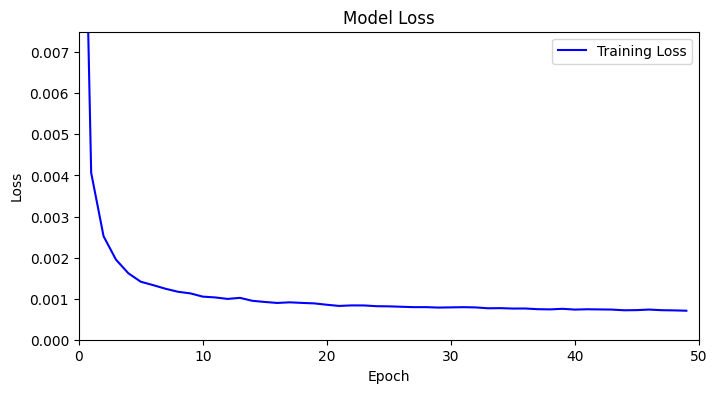

In [ ]:
#Loss Curve
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.axis([0, 50, 0.0, 0.0075])
plt.title('Model Loss')
plt.legend(loc=0)
# plt.grid(True)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show();

In [ ]:
predictions = model.predict(x_test)
print(predictions.shape)
print(y_test.shape)

In [ ]:
#reshape
predictions = np.reshape(predictions, (1152*1, 9))
real = np.reshape(y_test, (1152*1, 9))

# rescale
predictions = pd.DataFrame(predictions)
predictions = scaler.inverse_transform(predictions)
predictions = pd.DataFrame(predictions)
predictions = predictions.rename(columns={0: "pm10", 1: "pm25",
                                          2: "o3", 3: "so2",
                                          4: "no2", 5: "co", 6:"rh",7:"temp",8:"wind_spd"})

real = pd.DataFrame(real)
real = scaler.inverse_transform(real)
real = pd.DataFrame(real)

print(predictions.shape)
print(real.shape)

In [ ]:
predictions

In [ ]:
df_t = df_time[int(len(df)*0.8) : ]
df_t1 = df_t[4:]
df_final = pd.DataFrame()

indicators = ['pm10_lstm', 'pm25_lstm','o3_lstm', 'so2_lstm', 'no2_lstm','co_lstm','rh_lstm','temp_lstm','wind_spd_lstm']
m=-1
for i in indicator:
  m=m+1
  df_final[i] = real[m]
  df_final[indicators[m]] = predictions[i]

df_final["datetime"] = df_final.pm10
for i in range(0,len(df_final)):
   df_final.datetime.iloc[i] = df_t1.iloc[i]
df_final = df_final.set_index('datetime')
df_final

In [ ]:
fig, axes = plt.subplots(3,3)
fig = mpl.pyplot.gcf()
mpl.rcParams['axes.grid'] = False
plt.figure(figsize=(9,3))
plt.rcParams.update({
        "font.size": 13,})

df_final[['pm10', 'pm10_lstm']].plot(ax=axes[0,0])
df_final[['pm25', 'pm25_lstm']].plot(ax=axes[0,1])
df_final[['o3', 'o3_lstm']].plot(ax=axes[0,2])
df_final[['so2', 'so2_lstm']].plot(ax=axes[1,0])
df_final[['no2', 'no2_lstm']].plot(ax=axes[1,1])
df_final[['co', 'co_lstm']].plot(ax=axes[1,2])
df_final[['rh', 'rh_lstm']].plot(ax=axes[2,0])
df_final[['temp', 'temp_lstm']].plot(ax=axes[2,1])
df_final[['wind_spd', 'wind_spd_lstm']].plot(ax=axes[2,2])
plt.show()

In [ ]:
for i in indicator:
  rmse = mean_squared_error(df_final[f'{i}'],df_final[f'{i}_lstm'], squared=False)
  mse = mean_squared_error(df_final[f'{i}'],df_final[f'{i}_lstm'])
  mae = mean_absolute_error(df_final[f'{i}'], df_final[f'{i}_lstm'])
  mape = mean_absolute_percentage_error(df_final[f'{i}'], df_final[f'{i}_lstm'])
  print(f'{i} ----> RMSE: {rmse} ; MSE: {mse} ; MAE: {mae} ; MAPE: {mape}\n')
# # print('-----'*23)'

In [ ]:
plot_cols = ['ISPU_pm10','ISPU_pm25','ISPU_o3','ISPU_so2','ISPU_no2','ISPU_co','ISPU']
for i in plot_cols:
  predictions[i] = predictions.pm10

In [ ]:
def ConvertPM10(predictions):
    for i in range(0, len(predictions)):
      q1 = predictions.pm10.iloc[i] #pm10
      if q1 > 420:
        k, t , r = (q1 - 420),(500 - 420), (400 - 300)
        ISPU_pm10 = (r*k/t) + 300
      elif 350 < q1 <= 420:
        k, t , r = (q1 - 350),(420 - 350), (300 - 200)
        ISPU_pm10 = (r*k/t) + 200
      elif 150 < q1 <= 350:
        k, t , r = (q1 - 150),(350 - 150), (200 - 100)
        ISPU_pm10 = (r*k/t) + 100
      else :
        k, t , r = (q1 - 50),(150 - 50), (100 - 50)
        ISPU_pm10 = (r*k/t) + 50
      predictions.ISPU_pm10.iloc[i] = round(ISPU_pm10)

def ConvertPM25(predictions):
    for i in range(0, len(predictions)):
      q2 = predictions.pm25.iloc[i] #pm2,5
      if q2 > 250.4:
        k, t , r = (q2 - 250.4),(500 - 250.4), (400 - 300)
        ISPU_pm25 = (r*k/t) + 300
      elif 150.4 < q2 <= 250.4:
        k, t , r = (q2 - 150.4),(250.4 - 150.4), (300 - 200)
        ISPU_pm25 = (r*k/t) + 200
      elif 55.4 < q2 <= 150.4:
        k, t , r = (q2 - 55.4),(150.4 - 55.4), (200 - 100)
        ISPU_pm25 = (r*k/t) + 100
      else :
        k, t , r = (q2 - 15.5),(55.4 - 15.5), (100 - 50)
        ISPU_pm25 = (r*k/t) + 50
      predictions.ISPU_pm25.iloc[i] = round(ISPU_pm25)

def ConvertO3(predictions):
    for i in range(0, len(predictions)):
      q3 = predictions.o3.iloc[i] #o3
      if q3 > 800:
        k, t , r = (q3 - 800),(1000 - 800), (400 - 300)
        ISPU_o3 = (r*k/t) + 300
      elif 400 < q3 <= 800:
        k, t , r = (q3 - 400),(800 - 400), (300 - 200)
        ISPU_o3 = (r*k/t) + 200
      elif 235 < q3 <= 400:
        k, t , r = (q3 - 235),(400 - 235), (200 - 100)
        ISPU_o3 = (r*k/t) + 100
      else :
        k, t , r = (q3 - 120),(235 - 120), (100 - 50)
        ISPU_o3 = (r*k/t) + 50
      predictions.ISPU_o3.iloc[i] = round(ISPU_o3)

def ConvertSO2(predictions):
    for i in range(0, len(predictions)):
      q4 = predictions.so2.iloc[i] #so2
      if q4 > 800:
        k, t , r = (q4 - 800),(1200 - 800), (400 - 300)
        ISPU_so2 = (r*k/t) + 300
      elif 400< q4 <= 800:
        k, t , r = (q4 - 400),(800 - 400), (300 - 200)
        ISPU_so2 = (r*k/t) + 200
      elif 180 < q4 <= 400:
        k, t , r = (q4 - 180),(400 - 180), (200 - 100)
        ISPU_so2 = (r*k/t) + 100
      else :
        k, t , r = (q4 - 52),(180 - 52), (100 - 50)
        ISPU_so2 = (r*k/t) + 50
      predictions.ISPU_so2.iloc[i] = round(ISPU_so2)

def ConvertNO2(predictions):
    for i in range(0, len(predictions)):
      q5 = predictions.no2.iloc[i] #no2
      if q5 > 2260 :
        k, t , r = (q5 - 2260),(3000 - 2260), (400 - 300)
        ISPU_no2 = (r*k/t) + 300
      elif 1130 < q5 <= 2260 :
        k, t , r = (q5 - 1130),(2260 - 1130), (300 - 200)
        ISPU_no2 = (r*k/t) + 200
      elif 200 < q5 <= 1130 :
        k, t , r = (q5 - 200),(1130 - 200), (200 - 100)
        ISPU_no2 = (r*k/t) + 100
      else:
        k, t , r = (q5 - 80),(235 - 80), (100 - 50)
        ISPU_no2 = (r*k/t) + 50
      predictions.ISPU_no2.iloc[i] = round(ISPU_no2)

def ConvertNO2(predictions):
    for i in range(0, len(predictions)):
      q5 = predictions.no2.iloc[i] #no2
      if q5 > 2260 :
        k, t , r = (q5 - 2260),(3000 - 2260), (400 - 300)
        ISPU_no2 = (r*k/t) + 300
      elif 1130 < q5 <= 2260 :
        k, t , r = (q5 - 1130),(2260 - 1130), (300 - 200)
        ISPU_no2 = (r*k/t) + 200
      elif 200 < q5 <= 1130 :
        k, t , r = (q5 - 200),(1130 - 200), (200 - 100)
        ISPU_no2 = (r*k/t) + 100
      else:
        k, t , r = (q5 - 80),(235 - 80), (100 - 50)
        ISPU_no2 = (r*k/t) + 50
      predictions.ISPU_no2.iloc[i] = round(ISPU_no2)

def ConvertCO(predictions):
    for i in range(0, len(predictions)):
      q6 = predictions.co.iloc[i] #co
      if q6 > 30000 :
        k, t , r = (q6 - 30000),(45000 - 30000), (400 - 300)
        ISPU_co = (r*k/t) + 300
      elif 15000 < q6 <= 30000 :
        k, t , r = (q6 - 15000),(30000 - 15000), (300 - 200)
        ISPU_co = (r*k/t) + 200
      elif 8000 < q6 <= 15000 :
        k, t , r = (q6 - 8000),(15000 - 8000), (200 - 100)
        ISPU_co = (r*k/t) + 100
      else :
        k, t , r = (q6 - 4000),(8000 - 4000), (100 - 50)
        ISPU_co = (r*k/t) + 50
      predictions.ISPU_co.iloc[i] = round(ISPU_co)

In [ ]:
ConvertPM10(predictions)
ConvertPM25(predictions)
ConvertO3(predictions)
ConvertSO2(predictions)
ConvertNO2(predictions)
ConvertCO(predictions)

In [ ]:
dp = predictions[plot_cols]
for i in range(0,len(dp)):
  dp.ISPU.iloc[i] = 0

def ConvertISPU(dp):
  for i in range(0, len(dp)):
      maximum = dp.iloc[i].max()
      q1 = dp.ISPU_pm10.iloc[i] #pm10
      q2 = dp.ISPU_pm25.iloc[i] #pm2,5
      q3 = dp.ISPU_o3.iloc[i] #o3
      q4 = dp.ISPU_so2.iloc[i] #so2
      q5 = dp.ISPU_no2.iloc[i] #no2
      q6 = dp.ISPU_co.iloc[i]
      if maximum == q1:
        dp.ISPU.iloc[i] = q1
      elif maximum == q2 :
        dp.ISPU.iloc[i] = q2
      elif maximum == q3 :
        dp.ISPU.iloc[i] = q3
      elif maximum == q4 :
        dp.ISPU.iloc[i] = q4
      elif maximum == q5 :
        dp.ISPU.iloc[i] = q5
      else :
        dp.ISPU.iloc[i] = q6
  return dp

In [ ]:
ConvertISPU(dp)

real = real.rename(columns={0: "pm10", 1: "pm25",
                                          2: "o3", 3: "so2",
                                          4: "no2", 5: "co"})
for i in plot_cols :
  real[i] = real.pm10

ConvertPM10(real)
ConvertPM25(real)
ConvertO3(real)
ConvertSO2(real)
ConvertNO2(real)
ConvertCO(real)

In [ ]:
real

In [ ]:
plot_cols = ['ISPU_pm10','ISPU_pm25','ISPU_o3','ISPU_so2','ISPU_no2','ISPU_co','ISPU']
ds = real[plot_cols]
for i in range(0,len(ds)):
  ds.ISPU.iloc[i] = 0

In [ ]:
ConvertISPU(ds)

In [ ]:
df_ISPU = pd.DataFrame()
df_ISPU["datetime"] = dp.ISPU
df_ISPU["ISPU_asli"] = ds.ISPU
df_ISPU["ISPU_pred"] = dp.ISPU
df_ISPU

In [ ]:
for i in range(0,len(df_ISPU)):
   df_ISPU.datetime.iloc[i] = df_t1.iloc[i]
df_ISPU = df_ISPU.set_index('datetime')
df_ISPU["residu"] = abs(df_ISPU['ISPU_asli'] - df_ISPU['ISPU_pred'])

In [ ]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.figure(figsize=(12,4))
plt.plot(df_ISPU["ISPU_asli"], label='Nilai ISPU', color='orange')
plt.plot(df_ISPU["ISPU_pred"], label='Nilai ISPU LSTM', color='blue')
plt.plot(df_ISPU["residu"], label='Residu', color='green')
plt.axhline(y = 101, color = 'r', linestyle = 'dashed', label = 'Batas Nilai Sehat')
plt.title('Nilai Prediksi ISPU Bandar Lampung')
plt.legend(loc=0)
plt.ylabel('ISPU')
plt.xlabel('Date')
plt.show();

In [ ]:
rmse = np.sqrt(mean_squared_error(df_ISPU['ISPU_asli'],df_ISPU['ISPU_pred']))
print(rmse)

# Save Model

In [ ]:
model.save_weights('./checkpoints/my_checkpoint')

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')
model.save('model_fix_weather.h5')